In [4]:
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
import math
%run ./labeling.ipynb
from tqdm.auto import tqdm

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#FOR REPRODISIBILITY

In [30]:
train_df.iloc[:, 1]

0        293.990000
1        292.180000
2        291.750000
3        293.820000
4        294.750000
            ...    
21118      0.034960
21119      0.035100
21120      0.034990
21121      0.034900
21122      0.035185
Name: 1, Length: 21123, dtype: float64

In [26]:
train_images.shape[0]

21123

In [34]:
def train_cnn(training_df, test_df, params):
    """Trains and evaluates CNN on the given train and test data, respectively."""

    print("Training is starting ...")
    train_images = training_df.iloc[:, 3:].to_numpy()  # bu satır son sütun hariç her şeyi resimler dataframeine atar.
    train_labels = training_df.loc[:, 0]    # bu satır sadece son sütunu alır.
    train_prices = training_df.loc[: ,1]

    test_images = test_df.iloc[:, 3:].to_numpy()  # bu satır son sütun hariç her şeyi resimler dataframeine atar.
    test_labels = test_df.loc[:, 0]   # bu satır sadece son sütunu alır.
    test_prices = test_df.loc[:, 1]

    test_labels = keras.utils.to_categorical(test_labels, params["num_classes"])
    train_labels = keras.utils.to_categorical(train_labels, params["num_classes"])

#create pictures simple reshaping 225 in 15x15+1
    train_images = train_images.reshape(train_images.shape[0], params["input_w"], params["input_h"], 1) 
    test_images = test_images.reshape(test_images.shape[0], params["input_w"], params["input_h"], 1)



    # CNN model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(params["input_w"], params["input_h"], 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(params["num_classes"], activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, #not categorical_crossentropy
                  optimizer=keras.optimizers.Adadelta(), #not Adam
                  metrics=['accuracy', 'mae', 'mse']) #plus two

    # metrics.accuracy_score, metrics.recall_score, metrics.average_precision_score, metrics.confusion_matrix
    train_data_size = train_images.shape[0]
    test_data_size = test_images.shape[0]


    print("model will be trained with {} and be tested with {} sample".format(train_data_size,test_data_size))
    # fit the model to the training data
    print("Fitting model to the training data...")
    print("")
    model.fit(train_images, train_labels, batch_size=params["batch_size"], epochs=params["epochs"], verbose=0,validation_data=None)

    predictions = model.predict(test_images, batch_size=params["batch_size"], verbose=0)
    print(model.evaluate(test_images, test_labels, batch_size=params["batch_size"], verbose=0))
    
    predictions_train = model.predict(train_images, batch_size=params["batch_size"], verbose=0)
    print(model.evaluate(train_images, train_labels, batch_size=params["batch_size"], verbose=0))

    print("Train conf matrix: ") 
    print(confusion_matrix(np.array(reverse_one_hot(train_labels)),
                                                  np.array(reverse_one_hot(model.predict(train_images, batch_size=params["batch_size"], verbose=0)))))

    print("Test conf matrix: ") 
    print(confusion_matrix(np.array(reverse_one_hot(test_labels)),
                                                  np.array(reverse_one_hot(predictions))))



    # cur_pointer = train_data_size + 1
    # print("Calculating accuracy day by day...", end='\n\n')
    # for i in range(test_data_size-2):
    #     # train with 1 more image
    #     model.train_on_batch(np.reshape(data[train_data_size + 1 + i, :], (1, params["input_w"], params["input_h"], 1)),
    #                         np.reshape(labels[train_data_size + 1 + i, :], (1, params["num_classes"])))
    #
    #     # test with first untrained day which is the day after previously trained one
    #     loss_cur,acc_cur = model.test_on_batch(np.reshape(data[train_data_size + 1 + i + 1, :], (1, params["input_w"], params["input_h"], 1)),
    #                         np.reshape(labels[train_data_size + 1 + i + 1, :], (1, params["num_classes"])))
    #
    #     accuracies.append(acc_cur)
    #     losses.append(loss_cur)
    #
    #     # show values every 100 cycle
    #     if i % 100 == 0:
    #         print("{} to {} mean : ".format(i-100,i), np.mean(accuracies))

    return predictions, test_labels, test_prices, predictions_train, train_labels, train_prices

def reverse_one_hot(predictions):
    reversed_x = []
    for x in predictions:
        reversed_x.append(np.argmax(np.array(x)))
    return reversed_x




In [220]:
#ТУРЕЧИНА
train_df = pd.read_csv("E:/Host/Data/Bees/finance_ML/CNN-TA/data/1/outputOfPhase2Training.csv", header=None, index_col=None, delimiter=';')
test_df  = pd.read_csv("E:/Host/Data/Bees/finance_ML/CNN-TA/data/1/outputOfPhase2Test.csv", header=None, index_col=None, delimiter=';')

# sonundaki ; den dolayı son sütun nan geliyor.
train_df = train_df.iloc[:,:-1]
test_df = test_df.iloc[:,:-1]

# drop nan values
train_df = train_df.dropna(axis=0)
test_df = test_df.dropna(axis=0)

# drop first 15 row
train_df = train_df.iloc[15:, :]
test_df = test_df.iloc[15:,:]

#СВОИ ЛЕЙБЛЫ

# return_ = np.array((train_df[1].shift(-1)/train_df[1].shift(0)-1)*100)
# pl_mi   = np.array(np.where(return_ > 1.5,1, np.where(return_ < -1.5, 2, 0)))
# price   = np.array(train_df[1])
# return_ = pd.concat([pd.Series(price), pd.Series(return_),(pd.Series(pl_mi))], axis=1)
# train_df[0] = pl_mi
# train_df

In [19]:
%%time

# ГОТОВИМ ТРАЙН И ТЕСТ ИЗ TALIB С ЗАГРУЗКИ ДО КОНЦА
df1 = pd.read_csv("E:/Host/Data/Bees/finance_ML/df3.csv")

#ДОБАВИЛ +/-И ЦЕНУ
return_ = np.array((df1['close'].shift(-1)/df1['close'].shift(0)-1)*100)
pl_mi   = np.array(np.where(return_ > 1, 1, np.where(return_ < -1, 2, 0)))
price   = np.array(df1['close'])
df1[0] = pl_mi
df1[1] = price
df1[2] = return_
#СГРУПИРОВАЛИ ПО СИМБОЛАМ И РАЗБИЛИ И СНОВА СОБРАЛИ НА ТЕСТ И ТРАЙН
train_df = pd.DataFrame()
test_df = pd.DataFrame()
for yy in ['GAZP', 'GMKN', 'LKOH', 'ROSN', 'SBER', 'SBERP', 'VTBR']:
    
    df_f = df1[df1['symbol'] == yy]
    
    a, b = create_labels(df_f.iloc[:,:], 'close') #запуск лейбла из labling
    display(b)
    df_f[0] = a #перезапись вместо простого
    
    df_f_train = df_f.iloc[:int(len(df_f)*0.9), :]
    df_f_test  = df_f.iloc[int(len(df_f)*0.9):, :]
    train_df = train_df.append(df_f_train)
    test_df  = test_df.append(df_f_test)
#display(train_df)
#display(test_df)
# СКОМПОНОВАЛИ ПРАВИЛЬНЫЕ СТОЛБЦЫ
train_df = train_df[[0,1,2] + list(train_df.columns[8:-4])]
test_df  = test_df [[0,1,2]  + list(test_df.columns[8:-4])]
#print('result')
display(train_df.shape)
display(test_df.shape)
    

Calculating labels


C:\Users\afecn\anaconda3.1\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
C:\Users\afecn\anaconda3.1\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


(3484,)

Calculating labels


C:\Users\afecn\anaconda3.1\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(3249,)

Calculating labels


(4084,)

Calculating labels


(3362,)

Calculating labels


(3112,)

Calculating labels


(3112,)

Calculating labels


(3072,)

(21123, 292)

(2352, 292)

Wall time: 1min 39s


In [24]:
#ПОЧИСТИМ ОТ НАНОВ
display(train_df.shape)
display(test_df.shape)
display(np.unique(train_df[0], return_counts=True))
display(np.unique(test_df[0],  return_counts=True))
train_df.fillna(2, inplace=True)
test_df.fillna(2, inplace=True)
display(np.unique(train_df[0], return_counts=True))
display(np.unique(test_df[0],  return_counts=True))
display(train_df.shape)
display(test_df.shape)

(21123, 292)

(2352, 292)

(array([0., 1., 2.]), array([ 1290,  1311, 18522], dtype=int64))

(array([0., 1., 2.]), array([ 132,  132, 2088], dtype=int64))

(array([0., 1., 2.]), array([ 1290,  1311, 18522], dtype=int64))

(array([0., 1., 2.]), array([ 132,  132, 2088], dtype=int64))

(21123, 292)

(2352, 292)

In [21]:
%%time

# УРАВНИВАЕМ ВЫБОРКУ 1 2 3

l0_train = train_df.loc[train_df[0] == 0]
l1_train = train_df.loc[train_df[0] == 1]
l2_train = train_df.loc[train_df[0] == 2]
l0_size = l0_train.shape[0]
l1_size = l1_train.shape[0]
l2_size = l2_train.shape[0]
#l0_l1_ratio = int((l0_size//l1_size)/4)
#l0_l2_ratio = int((l0_size//l2_size)/4)

l0_l1_ratio = (l0_size//l1_size)
l0_l2_ratio = (l0_size//l2_size)
print("Before")
print("l0_size:",l0_size,"l1_size:", l1_size,"l2_size:",l2_size)
print("l0_l1_ratio:",l0_l1_ratio,"l0_l2_ratio:", l0_l2_ratio)

l1_new = pd.DataFrame()
l2_new = pd.DataFrame()
for idx, row in train_df.iterrows():
    if row[0] == 1:
        for i in range(l0_l1_ratio):
            l1_new = l1_new.append(row)
    if row[0] == 2:
        for i in range(l0_l2_ratio):
            l2_new = l2_new.append(row)

train_df = train_df.append(l1_new)
train_df = train_df.append(l2_new)



########################################################
l0_train = train_df.loc[train_df[0] == 0]
l1_train = train_df.loc[train_df[0] == 1]
l2_train = train_df.loc[train_df[0] == 2]
l0_size = l0_train.shape[0]
l1_size = l1_train.shape[0]
l2_size = l2_train.shape[0]
#l0_l1_ratio = int((l0_size//l1_size)/4)
#l0_l2_ratio = int((l0_size//l2_size)/4)

l0_l1_ratio = (l0_size//l1_size)
l0_l2_ratio = (l0_size//l2_size)
print("After")
print("l0_size:",l0_size,"l1_size:", l1_size,"l2_size:",l2_size)
print("l0_l1_ratio:",l0_l1_ratio,"l0_l2_ratio:", l0_l2_ratio)

######################################################


train_df.reset_index(drop=True, inplace=True)
test_df.reset_index (drop=True, inplace=True)

print("train_df size: ", train_df.shape)
#print(train_df.columns)


Before
l0_size: 1290 l1_size: 1311 l2_size: 18522
l0_l1_ratio: 0 l0_l2_ratio: 0
After
l0_size: 1290 l1_size: 1311 l2_size: 18522
l0_l1_ratio: 0 l0_l2_ratio: 0
train_df size:  (21123, 292)
Wall time: 1.78 s


In [77]:
# # shuffle
# #train_df = shuffle(train_df)  #ЗАКОМЕНТИЛ!!!!!!!!!!!!!!
# print(list(train_df.columns))
# train_df.columns = list(range(0,291))
# print(list(train_df.columns))
# # shuffle all!!!!
# train_df = np.transpose(shuffle(np.transpose(train_df.loc[:, :])))
# #ПРИВЕЛ В ПОРЯДОК
# train_df = train_df[[0,1] + shuffle(list(range(2,291)))]
# print(list(train_df.columns))
# train_df

In [7]:
test_df

,0,1,ADX_2,ADX_3,ADX_4,ADX_5,ADX_10,ADX_28,ADXR_2,ADXR_3,...,STOCHRSI_fastk,STOCHRSI_fastd,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,MAMA_mama
2787,0,132.280000,0.314672,-0.093550,-0.344437,-0.487267,-0.644011,-0.707232,0.028343,-0.251058,...,1.000000,-0.182089,-0.070274,-0.119200,-0.999949,-0.714277,-0.988846,-0.988640,-0.988839,-0.988311
2788,0,132.300000,0.591116,0.182888,-0.099354,-0.278324,-0.540237,-0.674363,0.430540,-0.190980,...,1.000000,0.484578,-0.070227,-0.119467,0.950370,0.452015,-0.988645,-0.988526,-0.988823,-0.988297
2789,0,131.500000,0.394303,0.233227,0.006743,-0.163296,-0.463737,-0.646265,0.471994,0.031632,...,0.575543,0.858514,-0.070132,-0.119371,0.937415,0.416628,-0.988563,-0.988437,-0.988730,-0.988252
2790,0,132.500000,0.466521,0.323925,0.120444,-0.046522,-0.383524,-0.614967,0.407133,0.224208,...,0.789107,0.788217,-0.070127,-0.119489,0.883516,0.293530,-0.988540,-0.988315,-0.988505,-0.988239
2791,0,133.320000,0.553570,0.403358,0.217065,0.055065,-0.307648,-0.583416,0.490044,0.292278,...,0.881641,0.748764,-0.070188,-0.118618,0.793094,0.130104,-0.988742,-0.988182,-0.988015,-0.988082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23470,0,0.036720,0.435219,-0.014808,-0.179933,-0.247614,-0.294007,-0.637749,0.311652,-0.102823,...,-1.000000,-1.000000,-0.070418,-0.119731,-0.563538,-0.982615,-0.999998,-0.999998,-0.999998,-0.999998
23471,0,0.036755,0.548040,0.072608,-0.150330,-0.256614,-0.349153,-0.657346,0.470870,-0.070134,...,-0.983100,-0.994367,-0.070418,-0.119730,-0.670690,-0.998737,-0.999998,-0.999998,-0.999998,-0.999999
23472,1,0.036930,-0.304551,-0.176461,-0.278979,-0.352487,-0.419774,-0.672588,0.085761,-0.141961,...,-0.744532,-0.909211,-0.070418,-0.119731,-0.764096,-0.996454,-0.999998,-0.999998,-0.999998,-0.999999
23473,0,0.037680,-0.353327,-0.512141,-0.463196,-0.481565,-0.495838,-0.684733,-0.383471,-0.272184,...,0.986753,-0.246960,-0.070418,-0.119732,-0.888286,-0.952881,-0.999998,-0.999998,-0.999998,-0.999999


In [57]:
profit()

test-1
test-5
test5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,0.549110,24,0.788591,24,-4.749730,23
1,-0.318549,67,0.586801,56,2.867266,45
2,0.053156,2245,0.487843,2124,-0.511981,2029
All,0.047590,2336,0.493632,2204,-0.485945,2097


train-1
train-5
train5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,-1.823786,111,-3.024951,93,-4.019567,68
1,2.013059,208,3.384687,174,3.497373,140
2,0.025992,20637,0.135456,19458,-0.162711,18623
All,0.035916,20956,0.149217,19725,-0.149428,18831


In [56]:
def profit():
    aa_all=pd.DataFrame()
    bb_all=pd.DataFrame()
    k = 10 #УБИРАЕМ ВЫСОКИЕ ПРОЦЕНТЫ

    result_df = pd.DataFrame({"prediction": np.argmax(predictions, axis=1),
                              "test_label":np.argmax(test_labels, axis=1),
                             "test_price":test_prices})

    result_df_train = pd.DataFrame({"prediction": np.argmax(predictions_train, axis=1),
                              "test_label":np.argmax(train_labels, axis=1),
                             "test_price":train_prices})
    #result_df.to_excel("cnn_result.xlsx", index=None)

    for ii in [-1,-5, 5]:
        print('test'+str(ii))
        result_df['test_price_1'] = (result_df['test_price'].shift(ii)/result_df['test_price']-1)*100
        result_df = result_df[result_df['test_price_1']>-k]
        result_df = result_df[result_df['test_price_1']< k]
        aa = pd.pivot_table(result_df, values = 'test_price_1', index='prediction', aggfunc=['mean', 'count'], margins=True)
        aa_all = pd.concat([aa_all, aa], axis=1)
    display(aa_all)

    for ii in [-1, -5, 5]:    
        print('train'+str(ii))
        result_df_train['test_price_1'] = (result_df_train['test_price'].shift(ii)/result_df_train['test_price']-1)*100
        result_df_train = result_df_train[result_df_train['test_price_1']>-k]
        result_df_train = result_df_train[result_df_train['test_price_1']< k]
        bb = pd.pivot_table(result_df_train, values = 'test_price_1', index='prediction', aggfunc=['mean', 'count'], margins=True)
        bb_all = pd.concat([bb_all, bb], axis=1)
    display(bb_all)

In [58]:
%%time
prifit = pd.DataFrame()
for i in range(10):
    # fill params dict before call train_cnn
    params = {"input_w": 17, "input_h": 17, "num_classes": 3, "batch_size": 1024, "epochs": 200}
    #params = {"input_w": 15, "input_h": 15, "num_classes": 3, "batch_size": 1024, "epochs": 100}
    # Buraya kadar olan yöntime izleyip verini fonksiyona yollayabilirsin.
    # Örneğin şu şekilde.
    predictions, test_labels, test_prices, predictions_train, train_labels, train_prices = train_cnn(train_df, test_df, params)
    print(i)
    profit()

Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3203858546659249, 0.8669217824935913, 0.1322842687368393, 0.06797898560762405]
[0.2375762083974237, 0.8860010504722595, 0.11233177781105042, 0.05114773288369179]
Train conf matrix: 
[[  105     0  1185]
 [    0   134  1177]
 [   21    25 18476]]
Test conf matrix: 
[[   4    0  128]
 [   0   20  112]
 [  18   55 2015]]
0
test-1
test-5
test5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,0.335931,22,0.558798,22,-4.700462,22
1,-0.236844,70,0.765680,58,3.088554,46
2,0.053636,2244,0.485528,2124,-0.521286,2029
All,0.047590,2336,0.493632,2204,-0.485945,2097


train-1
train-5
train5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,-1.793774,121,-3.095351,104,-3.222921,83
1,2.245169,140,4.116279,107,2.992880,71
2,0.031669,20695,0.144757,19514,-0.147715,18677
All,0.035916,20956,0.149217,19725,-0.149428,18831


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.34183095263786056, 0.8567177057266235, 0.13261057436466217, 0.07224180549383163]
[0.23932795413446908, 0.8840126991271973, 0.1094440221786499, 0.0520031675696373]
Train conf matrix: 
[[   36     0  1254]
 [    0   158  1153]
 [    8    35 18479]]
Test conf matrix: 
[[   9    1  122]
 [   0   21  111]
 [  27   76 1985]]
1
test-1
test-5
test5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,0.340874,36,0.252707,36,-5.223771,34
1,-0.156212,93,0.425675,77,2.960711,67
2,0.051395,2207,0.500282,2091,-0.520934,1996
All,0.047590,2336,0.493632,2204,-0.485945,2097


train-1
train-5
train5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,-1.903512,42,-3.076736,36,-3.765463,23
1,1.944491,177,3.340635,149,3.351913,114
2,0.023554,20737,0.130825,19540,-0.166331,18694
All,0.035916,20956,0.149217,19725,-0.149428,18831


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3293840692562311, 0.8626700639724731, 0.13939185440540314, 0.07084868103265762]
[0.24758399459542874, 0.8857643604278564, 0.11944042891263962, 0.05300062522292137]
Train conf matrix: 
[[   52     0  1238]
 [    0   181  1130]
 [   11    34 18477]]
Test conf matrix: 
[[   5    0  127]
 [   0   21  111]
 [  16   69 2003]]
2
test-1
test-5
test5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,0.315850,21,-0.171465,21,-5.470196,21
1,-0.094367,86,0.401258,72,3.034313,63
2,0.050540,2229,0.503399,2111,-0.544120,2013
All,0.047590,2336,0.493632,2204,-0.485945,2097


train-1
train-5
train5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,-2.082254,59,-3.958658,43,-3.393424,32
1,1.941717,197,3.405103,165,2.991394,131
2,0.023816,20700,0.130742,19517,-0.165907,18668
All,0.035916,20956,0.149217,19725,-0.149428,18831


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3235701363102919, 0.8745748400688171, 0.1180318221449852, 0.06544371694326401]
[0.24208557457246774, 0.8799886107444763, 0.10429699718952179, 0.053186334669589996]
Train conf matrix: 
[[   21     0  1269]
 [    0    51  1260]
 [    3     3 18516]]
Test conf matrix: 
[[   3    0  129]
 [   0   16  116]
 [  11   39 2038]]
3
test-1
test-5
test5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,0.546390,14,0.640015,14,-6.112375,14
1,-0.059212,52,0.536153,45,2.957118,37
2,0.046961,2270,0.491785,2145,-0.509710,2046
All,0.047590,2336,0.493632,2204,-0.485945,2097


train-1
train-5
train5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,-2.983096,21,-4.505087,14,-4.759539,7
1,3.308885,46,4.363670,31,2.879108,20
2,0.031744,20889,0.145890,19680,-0.150933,18804
All,0.035916,20956,0.149217,19725,-0.149428,18831


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3451255989723465, 0.8686224222183228, 0.12925180792808533, 0.07062634080648422]
[0.24436653567363337, 0.8851488828659058, 0.11096329241991043, 0.0528450608253479]
Train conf matrix: 
[[   29     0  1261]
 [    0   168  1143]
 [    2    20 18500]]
Test conf matrix: 
[[   3    0  129]
 [   0   25  107]
 [   5   68 2015]]
4
test-1
test-5
test5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,0.184466,8,-0.674102,8,-4.227941,8
1,-0.256352,89,0.454375,78,3.084437,67
2,0.059183,2239,0.499489,2118,-0.589446,2022
All,0.047590,2336,0.493632,2204,-0.485945,2097


train-1
train-5
train5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,-3.007433,28,-4.407261,19,-4.835945,11
1,2.008429,171,3.569410,140,3.158836,117
2,0.023772,20757,0.129170,19566,-0.167367,18703
All,0.035916,20956,0.149217,19725,-0.149428,18831


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.35487243168208066, 0.8592687249183655, 0.1358957141637802, 0.07418248802423477]
[0.23577357991434308, 0.8874213099479675, 0.10993534326553345, 0.05075698345899582]
Train conf matrix: 
[[   48     0  1242]
 [    0   226  1085]
 [   10    41 18471]]
Test conf matrix: 
[[   6    0  126]
 [   0   26  106]
 [  13   86 1989]]
5
test-1
test-5
test5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,0.125258,19,-0.119710,19,-5.845099,19
1,-0.310281,108,0.424761,91,3.004011,77
2,0.064419,2209,0.502190,2094,-0.569354,2001
All,0.047590,2336,0.493632,2204,-0.485945,2097


train-1
train-5
train5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,-1.841150,54,-3.345429,44,-3.321469,34
1,1.865417,249,3.712115,210,3.051375,167
2,0.018767,20653,0.118688,19471,-0.172331,18630
All,0.035916,20956,0.149217,19725,-0.149428,18831


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.34550239176166303, 0.867772102355957, 0.12296239286661148, 0.06863360106945038]
[0.23482789649324187, 0.8848174810409546, 0.10442183166742325, 0.05148877575993538]
Train conf matrix: 
[[   43     0  1247]
 [    0   145  1166]
 [    6    14 18502]]
Test conf matrix: 
[[   4    0  128]
 [   0   23  109]
 [  16   58 2014]]
6
test-1
test-5
test5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,0.266819,20,0.243605,20,-5.654873,20
1,-0.157407,77,0.780268,66,3.166525,55
2,0.052682,2239,0.487061,2118,-0.534168,2022
All,0.047590,2336,0.493632,2204,-0.485945,2097


train-1
train-5
train5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,-2.058936,47,-3.487719,38,-3.172519,28
1,2.246468,142,3.893197,113,2.892222,88
2,0.025542,20767,0.134664,19574,-0.159207,18715
All,0.035916,20956,0.149217,19725,-0.149428,18831


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.31975291071294926, 0.870323121547699, 0.12315802276134491, 0.06676460057497025]
[0.2415267834678403, 0.8810775279998779, 0.10717198997735977, 0.05286794528365135]
Train conf matrix: 
[[   32     0  1258]
 [    0    65  1246]
 [    3     5 18514]]
Test conf matrix: 
[[   4    0  128]
 [   0   17  115]
 [  13   49 2026]]
7
test-1
test-5
test5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,0.300165,17,0.762065,17,-5.908694,17
1,-0.356446,62,0.648507,50,3.034465,38
2,0.056787,2257,0.487873,2137,-0.506311,2042
All,0.047590,2336,0.493632,2204,-0.485945,2097


train-1
train-5
train5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,-3.308830,33,-3.210014,21,-2.564723,10
1,2.790784,58,3.933862,41,3.523515,25
2,0.033549,20865,0.144913,19663,-0.153028,18796
All,0.035916,20956,0.149217,19725,-0.149428,18831


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3324723630940833, 0.8698979616165161, 0.12559807300567627, 0.06816766411066055]
[0.2361408267552014, 0.881314218044281, 0.1067594364285469, 0.05168791487812996]
Train conf matrix: 
[[   29     0  1261]
 [    0    68  1243]
 [    2     1 18519]]
Test conf matrix: 
[[   4    0  128]
 [   0   16  116]
 [  15   47 2026]]
8
test-1
test-5
test5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,0.404795,19,0.953539,19,-5.570929,19
1,-0.192451,60,0.332950,52,3.070585,44
2,0.050965,2257,0.493453,2133,-0.515380,2034
All,0.047590,2336,0.493632,2204,-0.485945,2097


train-1
train-5
train5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,-2.229731,27,-4.511263,20,-2.728442,14
1,2.834622,60,3.825530,46,2.335151,35
2,0.030801,20869,0.145356,19659,-0.152135,18782
All,0.035916,20956,0.149217,19725,-0.149428,18831


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.33094871976748613, 0.8741496801376343, 0.12147340178489685, 0.06655223667621613]
[0.2385919547279083, 0.882024347782135, 0.10517336428165436, 0.05223085358738899]
Train conf matrix: 
[[   43     0  1247]
 [    0    75  1236]
 [    6     3 18513]]
Test conf matrix: 
[[   2    0  130]
 [   0   16  116]
 [   7   43 2038]]
9
test-1
test-5
test5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,0.016386,9,0.306798,9,-4.913863,9
1,0.006915,56,0.704074,50,3.071727,43
2,0.048717,2271,0.489511,2145,-0.541264,2045
All,0.047590,2336,0.493632,2204,-0.485945,2097


train-1
train-5
train5


,mean,count,mean,count,mean,count
,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1,test_price_1
prediction,,,,,,
0,-2.467262,44,-4.047686,34,-3.443351,24
1,2.395814,69,3.502414,55,2.068921,44
2,0.033388,20843,0.147092,19636,-0.150417,18763
All,0.035916,20956,0.149217,19725,-0.149428,18831


Wall time: 3h 21min 47s


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.31313639412931843, 0.8737244606018066, 0.12248800694942474, 0.06522788852453232]
[0.238821637028434, 0.8826870918273926, 0.10675288736820221, 0.05212375149130821]
Train conf matrix: 
[[   52     0  1238]
 [    0    89  1222]
 [   12     6 18504]]
Test conf matrix: 
[[   6    0  126]
 [   0   17  115]
 [  14   42 2032]]
0
test-1


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.095642,20
1,0.185939,55
2,0.043800,2261
All,0.047590,2336


test-5


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.068423,20
1,0.710228,49
2,0.493926,2135
All,0.493632,2204


test5


,mean,count
,test_price_1,test_price_1
prediction,,
0,-5.617228,19
1,3.127926,40
2,-0.509036,2038
All,-0.485945,2097


train-1


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.233496,59
1,2.612053,84
2,0.031953,20813
All,0.035916,20956


train-5


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.062925,47
1,4.155305,65
2,0.143638,19613
All,0.149217,19725


train5


,mean,count
,test_price_1,test_price_1
prediction,,
0,-4.131565,29
1,2.596337,48
2,-0.150298,18754
All,-0.149428,18831


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3472589319255076, 0.8639456033706665, 0.13104698061943054, 0.07041913270950317]
[0.2437705455727691, 0.8844860792160034, 0.11431489884853363, 0.05280730500817299]
Train conf matrix: 
[[   41     0  1249]
 [    0   148  1163]
 [    3    25 18494]]
Test conf matrix: 
[[   2    0  130]
 [   0   21  111]
 [   4   75 2009]]
1
test-1


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.036639,6
1,-0.249312,94
2,0.060298,2236
All,0.047590,2336


test-5


,mean,count
,test_price_1,test_price_1
prediction,,
0,-1.051166,6
1,0.273214,82
2,0.506554,2116
All,0.493632,2204


test5


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.661188,6
1,2.770943,70
2,-0.589324,2021
All,-0.485945,2097


train-1


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.828341,39
1,2.218469,157
2,0.024791,20760
All,0.035916,20956


train-5


,mean,count
,test_price_1,test_price_1
prediction,,
0,-4.385668,28
1,3.809385,127
2,0.131953,19570
All,0.149217,19725


train5


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.569939,19
1,3.309162,100
2,-0.165453,18712
All,-0.149428,18831


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.32959715363119735, 0.8690476417541504, 0.1297387331724167, 0.06820107996463776]
[0.2356739306820391, 0.8868532180786133, 0.1117224246263504, 0.050866954028606415]
Train conf matrix: 
[[   97     0  1193]
 [    0   179  1132]
 [   22    43 18457]]
Test conf matrix: 
[[   5    0  127]
 [   0   21  111]
 [  19   51 2018]]
2
test-1


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.549110,24
1,-0.318549,67
2,0.053156,2245
All,0.047590,2336


test-5


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.788591,24
1,0.586801,56
2,0.487843,2124
All,0.493632,2204


test5


,mean,count
,test_price_1,test_price_1
prediction,,
0,-4.749730,23
1,2.867266,45
2,-0.511981,2029
All,-0.485945,2097


train-1


,mean,count
,test_price_1,test_price_1
prediction,,
0,-1.823786,111
1,2.013059,208
2,0.025992,20637
All,0.035916,20956


train-5


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.024951,93
1,3.384687,174
2,0.135456,19458
All,0.149217,19725


train5


,mean,count
,test_price_1,test_price_1
prediction,,
0,-4.019567,68
1,3.497373,140
2,-0.162711,18623
All,-0.149428,18831


Wall time: 1h 19s


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.31185711707387653, 0.8686224222183228, 0.12996064126491547, 0.06609251350164413]
[0.24274735890548632, 0.8866164684295654, 0.11491499096155167, 0.0521455742418766]
Train conf matrix: 
[[   67     0  1223]
 [    0   179  1132]
 [   10    30 18482]]
Test conf matrix: 
[[   3    0  129]
 [   0   22  110]
 [  14   56 2018]]
0
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.353759,17
1,-0.177372,74
2,0.052687,2245
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-1.984199,74
1,1.943856,193
2,0.025344,20689
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3202409855767983, 0.8741496801376343, 0.1261793076992035, 0.06652305275201797]
[0.2348115706673198, 0.884154736995697, 0.10899274051189423, 0.05107719823718071]
Train conf matrix: 
[[   41     0  1249]
 [    0   147  1164]
 [    2    32 18488]]
Test conf matrix: 
[[   5    0  127]
 [   0   19  113]
 [  13   43 2032]]
1
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.449613,18
1,-0.124102,58
2,0.048795,2260
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.135073,39
1,2.150463,163
2,0.025268,20754
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.33268572420490033, 0.8652210831642151, 0.13195590674877167, 0.06864054501056671]
[0.24394758556487686, 0.8831132054328918, 0.1133624017238617, 0.05285964161157608]
Train conf matrix: 
[[   50     0  1240]
 [    0   106  1205]
 [   11    13 18498]]
Test conf matrix: 
[[   4    0  128]
 [   0   21  111]
 [  17   61 2010]]
2
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.142634,21
1,-0.209305,78
2,0.055656,2237
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.952252,56
1,2.556057,104
2,0.031360,20796
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.33192440502497617, 0.8715986609458923, 0.12767218053340912, 0.06847579032182693]
[0.24295780574054152, 0.8810775279998779, 0.11051148176193237, 0.0530405230820179]
Train conf matrix: 
[[   34     0  1256]
 [    0    66  1245]
 [    6     5 18511]]
Test conf matrix: 
[[   6    0  126]
 [   0   18  114]
 [  13   49 2026]]
3
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.120836,19
1,-0.258365,63
2,0.055525,2254
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.194846,37
1,2.572334,61
2,0.032456,20858
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3292739038564721, 0.8728741407394409, 0.12397342920303345, 0.06719712167978287]
[0.2357300061466048, 0.8831605315208435, 0.1049615815281868, 0.05157823488116264]
Train conf matrix: 
[[   32     0  1258]
 [    0   110  1201]
 [    1     8 18513]]
Test conf matrix: 
[[   4    0  128]
 [   0   20  112]
 [   9   50 2029]]
4
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.019740,13
1,-0.281922,67
2,0.057765,2256
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.707243,32
1,2.264472,107
2,0.028678,20817
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.32482138134184335, 0.8690476417541504, 0.12724901735782623, 0.06761054694652557]
[0.23610135738085386, 0.8866638541221619, 0.1096116155385971, 0.05114684998989105]
Train conf matrix: 
[[   52     0  1238]
 [    0   217  1094]
 [    7    55 18460]]
Test conf matrix: 
[[   5    0  127]
 [   0   23  109]
 [   7   65 2016]]
5
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.187079,12
1,-0.055257,83
2,0.052656,2241
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.356185,51
1,2.124571,249
2,0.016645,20656
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.34095666663987295, 0.865646243095398, 0.12979114055633545, 0.07081148773431778]
[0.23771205323455133, 0.8832552433013916, 0.10910803079605103, 0.0518038235604763]
Train conf matrix: 
[[   48     0  1242]
 [    0    92  1219]
 [    3     2 18517]]
Test conf matrix: 
[[   5    0  127]
 [   0   19  113]
 [  14   62 2012]]
6
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.419855,19
1,-0.171321,78
2,0.052058,2239
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.570290,47
1,2.418059,83
2,0.032304,20826
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3353324518317268, 0.8694728016853333, 0.12604883313179016, 0.06912709027528763]
[0.23718464477749163, 0.883586585521698, 0.10771692544221878, 0.051610060036182404]
Train conf matrix: 
[[   35     0  1255]
 [    0   121  1190]
 [    2    12 18508]]
Test conf matrix: 
[[   6    0  126]
 [   0   22  110]
 [  15   56 2017]]
7
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.280996,21
1,-0.223577,75
2,0.054482,2240
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.323829,33
1,2.251252,120
2,0.028467,20803
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3375715901251553, 0.8635203838348389, 0.13125832378864288, 0.07044297456741333]
[0.2355017128836074, 0.8849121928215027, 0.10930918902158737, 0.05099216848611832]
Train conf matrix: 
[[   83     0  1207]
 [    0   115  1196]
 [   15    13 18494]]
Test conf matrix: 
[[   8    0  124]
 [   0   21  111]
 [  18   68 2002]]
8
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.636375,26
1,-0.332539,84
2,0.055058,2226
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.203580,91
1,2.378900,110
2,0.033318,20755
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.32242680406894814, 0.8728741407394409, 0.1267682909965515, 0.06663737446069717]
[0.23722793256469518, 0.8822137117385864, 0.10892325639724731, 0.05161181092262268]
Train conf matrix: 
[[   26     0  1264]
 [    0    96  1215]
 [    5     4 18513]]
Test conf matrix: 
[[   2    0  130]
 [   0   14  118]
 [   4   47 2037]]
9
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.351247,6
1,-0.619470,59
2,0.065974,2271
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-4.064645,26
1,2.399761,90
2,0.030824,20840
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.323611532547036, 0.865646243095398, 0.12952224910259247, 0.06748909503221512]
[0.23923976665130536, 0.8856223225593567, 0.11181231588125229, 0.05168139189481735]
Train conf matrix: 
[[   60     0  1230]
 [    0   167  1144]
 [   12    30 18480]]
Test conf matrix: 
[[   5    0  127]
 [   0   26  106]
 [  18   65 2005]]
10
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.557481,23
1,-0.147645,87
2,0.049953,2226
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.183089,69
1,1.967476,178
2,0.026708,20709
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3451656760001669, 0.8715986609458923, 0.11795870214700699, 0.06892886012792587]
[0.24792907454353139, 0.8793731927871704, 0.10268835723400116, 0.0545894019305706]
Train conf matrix: 
[[   18     0  1272]
 [    0    37  1274]
 [    1     1 18520]]
Test conf matrix: 
[[   2    0  130]
 [   0   15  117]
 [   7   48 2033]]
11
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.143208,9
1,-0.172619,60
2,0.053039,2267
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.185101,16
1,3.145027,32
2,0.033623,20908
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3244938868649152, 0.8711734414100647, 0.1268845945596695, 0.06660515815019608]
[0.23855568046713285, 0.8831132054328918, 0.1107553169131279, 0.05178710073232651]
Train conf matrix: 
[[   62     0  1228]
 [    0    83  1228]
 [    5     8 18509]]
Test conf matrix: 
[[   4    0  128]
 [   0   14  118]
 [  13   44 2031]]
12
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.082662,17
1,-0.309887,54
2,0.057091,2265
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.427471,63
1,2.841760,76
2,0.033128,20817
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.33368209450423314, 0.8618197441101074, 0.13066443800926208, 0.06943211704492569]
[0.24085582210835546, 0.8841073513031006, 0.1122531145811081, 0.052114084362983704]
Train conf matrix: 
[[   53     0  1237]
 [    0   122  1189]
 [   11    11 18500]]
Test conf matrix: 
[[   4    0  128]
 [   0   21  111]
 [  18   68 2002]]
13
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.780537,22
1,-0.403478,85
2,0.057557,2229
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.235572,60
1,2.746268,117
2,0.027214,20779
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.33404481593443425, 0.8660714030265808, 0.13313205540180206, 0.07000220566987991]
[0.24453041382835528, 0.888320803642273, 0.11612609028816223, 0.05267307162284851]
Train conf matrix: 
[[   48     0  1242]
 [    0   295  1016]
 [    6    95 18421]]
Test conf matrix: 
[[   3    0  129]
 [   0   27  105]
 [   8   73 2007]]
14
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.954378,11
1,-0.247675,96
2,0.055832,2229
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.595444,49
1,1.571493,368
2,0.014681,20539
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.32518482289346706, 0.870323121547699, 0.1268370896577835, 0.06687764078378677]
[0.23674809329128116, 0.8839179873466492, 0.11002261936664581, 0.051316335797309875]
Train conf matrix: 
[[   78     0  1212]
 [    0    99  1212]
 [   15    13 18494]]
Test conf matrix: 
[[   2    0  130]
 [   0   21  111]
 [  16   48 2024]]
15
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.855872,18
1,-0.180803,66
2,0.047824,2252
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.087295,88
1,2.521252,100
2,0.032946,20768
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.32681595022175586, 0.8694728016853333, 0.12513121962547302, 0.06765450537204742]
[0.23658311298183266, 0.8834919333457947, 0.1069648489356041, 0.05153350532054901]
Train conf matrix: 
[[   33     0  1257]
 [    0   112  1199]
 [    3     2 18517]]
Test conf matrix: 
[[   2    0  130]
 [   0   17  115]
 [   5   57 2026]]
16
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.599287,7
1,-0.005573,71
2,0.051268,2258
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.666832,33
1,2.525790,100
2,0.028242,20823
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.33698954651144897, 0.8694728016853333, 0.12114130705595016, 0.06760520488023758]
[0.2349640233716871, 0.8837286233901978, 0.10309820622205734, 0.05156262591481209]
Train conf matrix: 
[[   21     0  1269]
 [    0   151  1160]
 [    5    22 18495]]
Test conf matrix: 
[[   2    0  130]
 [   0   19  113]
 [   5   59 2024]]
17
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.080509,7
1,-0.225024,74
2,0.056434,2255
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.241483,25
1,2.061835,161
2,0.022954,20770
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.35443967905174306, 0.8618197441101074, 0.13344767689704895, 0.07243838161230087]
[0.24626216032000725, 0.8833498954772949, 0.11342935264110565, 0.05344241112470627]
Train conf matrix: 
[[   45     0  1245]
 [    0   132  1179]
 [    8    32 18482]]
Test conf matrix: 
[[   4    0  128]
 [   0   18  114]
 [  19   64 2005]]
18
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.504362,23
1,-0.180346,79
2,0.050948,2234
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.700775,47
1,2.227074,147
2,0.026598,20762
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.32268195492880686, 0.8741496801376343, 0.12880165874958038, 0.06689900904893875]
[0.2366931136027885, 0.8858590126037598, 0.11050482094287872, 0.05128706991672516]
Train conf matrix: 
[[  102     0  1188]
 [    0   143  1168]
 [   22    33 18467]]
Test conf matrix: 
[[   6    0  126]
 [   0   15  117]
 [  14   39 2035]]
19
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.124718,20
1,-0.604886,50
2,0.063508,2266
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.015885,120
1,1.809823,157
2,0.034355,20679
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.32526835616754024, 0.8711734414100647, 0.12653633952140808, 0.06627798825502396]
[0.24408864785421924, 0.8811721801757812, 0.11203696578741074, 0.0528850294649601]
Train conf matrix: 
[[   43     0  1247]
 [    0    60  1251]
 [    5     7 18510]]
Test conf matrix: 
[[   1    0  131]
 [   0   19  113]
 [   3   56 2029]]
20
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.675648,4
1,-0.402037,71
2,0.062989,2261
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.807762,43
1,2.522770,54
2,0.035341,20859
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3352839790639423, 0.8639456033706665, 0.12648437917232513, 0.06891016662120819]
[0.2378405134087738, 0.8855276107788086, 0.1067337915301323, 0.051653195172548294]
Train conf matrix: 
[[   24     0  1266]
 [    0   178  1133]
 [    1    18 18503]]
Test conf matrix: 
[[   1    0  131]
 [   0   20  112]
 [   6   71 2011]]
21
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.082652,7
1,-0.037971,88
2,0.050841,2241
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.655330,22
1,2.122945,180
2,0.020668,20754
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.32756925440158974, 0.8720238208770752, 0.12310227751731873, 0.06664964556694031]
[0.2375161071777829, 0.884154736995697, 0.10583704710006714, 0.05165424570441246]
Train conf matrix: 
[[   43     0  1247]
 [    0   131  1180]
 [    2    18 18502]]
Test conf matrix: 
[[   2    0  130]
 [   0   22  110]
 [   5   56 2027]]
22
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.436188,7
1,-0.060914,73
2,0.049896,2256
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.077997,39
1,2.428469,134
2,0.026334,20783
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3298319134176994, 0.865646243095398, 0.13186657428741455, 0.06967433542013168]
[0.23637905102239912, 0.8874686360359192, 0.11174483597278595, 0.0507500134408474]
Train conf matrix: 
[[   43     0  1247]
 [    0   208  1103]
 [    4    23 18495]]
Test conf matrix: 
[[   2    0  130]
 [   0   25  107]
 [   5   74 2009]]
23
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.955917,7
1,-0.267054,95
2,0.064115,2234
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.861702,41
1,2.017053,212
2,0.021368,20703
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.32187366140942997, 0.8707482814788818, 0.12455911934375763, 0.067467100918293]
[0.24067525509541185, 0.8825924396514893, 0.10653730481863022, 0.05249059945344925]
Train conf matrix: 
[[   36     0  1254]
 [    0    96  1215]
 [    4     7 18511]]
Test conf matrix: 
[[   3    0  129]
 [   0   20  112]
 [   6   57 2025]]
24
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.765484,9
1,-0.245715,74
2,0.060472,2253
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.084210,38
1,2.390475,92
2,0.031208,20826
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3296807653644458, 0.8690476417541504, 0.12554576992988586, 0.06816214323043823]
[0.2386075950827793, 0.8834919333457947, 0.10718995332717896, 0.05202643945813179]
Train conf matrix: 
[[   20     0  1270]
 [    0   139  1172]
 [    0    19 18503]]
Test conf matrix: 
[[   2    0  130]
 [   0   19  113]
 [   6   59 2023]]
25
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.001810,8
1,-0.428851,75
2,0.063613,2253
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.589811,19
1,2.187049,142
2,0.024540,20795
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3426168151453239, 0.8596938848495483, 0.14192713797092438, 0.07352129369974136]
[0.2536591831355735, 0.8867585062980652, 0.12205047905445099, 0.05410435423254967]
Train conf matrix: 
[[   58     0  1232]
 [    0   218  1093]
 [    6    61 18455]]
Test conf matrix: 
[[   6    0  126]
 [   0   28  104]
 [  15   85 1988]]
26
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.426198,21
1,-0.243434,108
2,0.058229,2207
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.439075,59
1,1.764580,258
2,0.021382,20639
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.32582323952597014, 0.867772102355957, 0.12769882380962372, 0.06818769127130508]
[0.2376417491814463, 0.8846281170845032, 0.10854500532150269, 0.05157167464494705]
Train conf matrix: 
[[   42     0  1248]
 [    0   158  1153]
 [    3    33 18486]]
Test conf matrix: 
[[   3    0  129]
 [   0   22  110]
 [   8   64 2016]]
27
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.272673,11
1,-0.122376,82
2,0.055375,2243
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.913724,40
1,1.985555,179
2,0.024777,20737
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.322995354123667, 0.8762755393981934, 0.12432432174682617, 0.0658363476395607]
[0.24269340142197823, 0.8808407783508301, 0.11002665758132935, 0.05294100567698479]
Train conf matrix: 
[[   23     0  1267]
 [    0    77  1234]
 [    5    11 18506]]
Test conf matrix: 
[[   2    0  130]
 [   0   18  114]
 [   4   43 2041]]
28
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-1.046853,6
1,0.053644,57
2,0.050328,2273
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-3.809268,24
1,2.581147,73
2,0.031433,20859
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3268676296788819, 0.865646243095398, 0.13387711346149445, 0.0691591277718544]
[0.2435431651408116, 0.8874213099479675, 0.11485563963651657, 0.05233088880777359]
Train conf matrix: 
[[   29     0  1261]
 [    0   254  1057]
 [    6    54 18462]]
Test conf matrix: 
[[   6    0  126]
 [   0   26  106]
 [  13   71 2004]]
29
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.141764,19
1,-0.042414,92
2,0.050508,2225
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.600396,33
1,1.901860,290
2,0.013907,20633
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3536227094072874, 0.8503401279449463, 0.1419622004032135, 0.07606136798858643]
[0.24181774292616143, 0.8876579999923706, 0.11561515182256699, 0.05170169845223427]
Train conf matrix: 
[[  100     0  1190]
 [    0   177  1134]
 [   26    23 18473]]
Test conf matrix: 
[[   9    0  123]
 [   0   21  111]
 [  25   93 1970]]
30
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.253443,34
1,-0.187764,108
2,0.055986,2194
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.117327,119
1,2.180426,182
2,0.029426,20655
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.33143395753133864, 0.8686224222183228, 0.12645269930362701, 0.0681171640753746]
[0.23952116321130204, 0.8832552433013916, 0.10862445831298828, 0.05214392766356468]
Train conf matrix: 
[[   22     0  1268]
 [    0   133  1178]
 [    1    19 18502]]
Test conf matrix: 
[[   1    0  131]
 [   0   19  113]
 [   4   61 2023]]
31
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.407570,5
1,0.003028,77
2,0.050122,2254
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-4.090644,21
1,2.145386,142
2,0.025678,20793
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3266944092552678, 0.8754251599311829, 0.11906064301729202, 0.06567450612783432]
[0.2374596375544708, 0.8812195062637329, 0.10363401472568512, 0.052240945398807526]
Train conf matrix: 
[[   36     0  1254]
 [    0    68  1243]
 [    8     4 18510]]
Test conf matrix: 
[[   7    0  125]
 [   0   14  118]
 [  12   38 2038]]
32
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.024227,19
1,0.042748,50
2,0.048299,2267
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.389023,41
1,2.680310,62
2,0.032822,20853
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3190994147135287, 0.8741496801376343, 0.13230188190937042, 0.06698760390281677]
[0.24213509958731047, 0.8836812973022461, 0.11441109329462051, 0.052327901124954224]
Train conf matrix: 
[[   43     0  1247]
 [    0   130  1181]
 [    8    21 18493]]
Test conf matrix: 
[[   7    0  125]
 [   0   18  114]
 [  20   37 2031]]
33
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.267643,27
1,-0.008702,53
2,0.046279,2256
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.549130,49
1,2.024087,135
2,0.029093,20772
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.31817283415469994, 0.8715986609458923, 0.1254272162914276, 0.06585153192281723]
[0.2433408017197562, 0.881314218044281, 0.11001624166965485, 0.0528750941157341]
Train conf matrix: 
[[   30     0  1260]
 [    0    74  1237]
 [    8     2 18512]]
Test conf matrix: 
[[   5    0  127]
 [   0   19  113]
 [  14   48 2026]]
34
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.172656,19
1,-0.380055,64
2,0.058684,2253
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.408394,35
1,3.027347,64
2,0.030839,20857
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3345493802002498, 0.863095223903656, 0.136691614985466, 0.07091685384511948]
[0.23809651607411303, 0.8878000378608704, 0.11362458020448685, 0.05108605697751045]
Train conf matrix: 
[[   78     0  1212]
 [    0   207  1104]
 [   17    37 18468]]
Test conf matrix: 
[[   8    0  124]
 [   0   21  111]
 [  18   69 2001]]
35
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.039889,26
1,-0.453928,85
2,0.066840,2225
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.033692,88
1,2.000352,225
2,0.023328,20643
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.34543141053647414, 0.8601190447807312, 0.13276751339435577, 0.0717124417424202]
[0.23678035247392493, 0.888320803642273, 0.1104217991232872, 0.05122634395956993]
Train conf matrix: 
[[   86     0  1204]
 [    0   208  1103]
 [   14    38 18470]]
Test conf matrix: 
[[   4    0  128]
 [   0   23  109]
 [  17   75 1996]]
36
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.588214,21
1,-0.235343,94
2,0.054453,2221
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-1.844920,96
1,1.853363,229
2,0.024495,20631
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...

[0.3346225292909713, 0.865646243095398, 0.13314683735370636, 0.06963159143924713]
[0.24412954566814296, 0.8861904144287109, 0.11528253555297852, 0.052476365119218826]
Train conf matrix: 
[[   58     0  1232]
 [    0   189  1122]
 [   11    39 18472]]
Test conf matrix: 
[[   5    0  127]
 [   0   19  113]
 [  16   60 2012]]
37
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.684060,21
1,-0.306762,74
2,0.053327,2241
All,0.047590,2336


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-2.378703,65
1,1.925907,211
2,0.024222,20680
All,0.035916,20956


Training is starting ...
model will be trained with 21123 and be tested with 2352 sample
Fitting model to the training data...



KeyboardInterrupt: 

Training is starting ...
model will be trained with 40677 and be tested with 4698 sample
Fitting model to the training data...

[1.4456909573702368, 0.5623669624328613, 0.32686862349510193, 0.2134956419467926]
[0.20787611381063847, 0.9561176896095276, 0.10909219831228256, 0.03163333237171173]
Train conf matrix: 
[[ 9740   747   990]
 [   28 15040     8]
 [    0    12 14112]]
Test conf matrix: 
[[2329  399  694]
 [ 393  155  141]
 [ 316  113  158]]
0
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.054259,3030
1,0.186894,664
2,-0.056135,985
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.007174,9765
1,0.903642,15479
2,-0.856986,14771
All,0.031460,40015


Training is starting ...
model will be trained with 40677 and be tested with 4698 sample
Fitting model to the training data...

[1.3539734598219064, 0.5489569902420044, 0.3321998715400696, 0.21572284400463104]
[0.20199429918525932, 0.9489883780479431, 0.10377389937639236, 0.031721942126750946]
Train conf matrix: 
[[ 9454  1413   610]
 [   12 15064     0]
 [    8    32 14084]]
Test conf matrix: 
[[2275  604  543]
 [ 391  175  123]
 [ 309  149  129]]
1
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.048750,2967
1,0.073005,921
2,0.026967,791
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.009805,9472
1,0.865182,16186
2,-0.881248,14357
All,0.031460,40015


Training is starting ...
model will be trained with 40677 and be tested with 4698 sample
Fitting model to the training data...

[1.3406406066020837, 0.5395913124084473, 0.3388422429561615, 0.2164279669523239]
[0.20933365613910088, 0.954446017742157, 0.10943060368299484, 0.03210509195923805]
Train conf matrix: 
[[ 9648   715  1114]
 [    0 15064    12]
 [   12     0 14112]]
Test conf matrix: 
[[2223  497  702]
 [ 356  153  180]
 [ 311  117  159]]
2
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.012198,2882
1,0.174371,763
2,0.062872,1034
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.013599,9658
1,0.905935,15458
2,-0.846615,14899
All,0.031460,40015


Training is starting ...
model will be trained with 40677 and be tested with 4698 sample
Fitting model to the training data...

[1.3460057466879658, 0.5421456098556519, 0.335931658744812, 0.21416498720645905]
[0.22539893681452297, 0.9502913355827332, 0.11770018190145493, 0.034830667078495026]
Train conf matrix: 
[[ 9499   755  1223]
 [   20 15044    12]
 [    0    12 14112]]
Test conf matrix: 
[[2256  412  754]
 [ 415  136  138]
 [ 332  100  155]]
3
test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.047295,2995
1,0.239168,643
2,-0.059775,1041
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.005475,9516
1,0.901386,15490
2,-0.842927,15009
All,0.031460,40015


Training is starting ...
model will be trained with 40677 and be tested with 4698 sample
Fitting model to the training data...



KeyboardInterrupt: 

In [111]:
zz= pd.DataFrame(train_prices)
zz['acc'] = np.where((np.argmax(train_labels, axis=1))==(np.argmax(predictions_train, axis=1)),1,0)
zz['real']  = np.argmax(train_labels, axis=1)
zz['for'] = np.argmax(predictions_train, axis=1)
display(zz['acc'].mean())
zz
pd.pivot_table(zz, index='real', values='acc', columns='for', aggfunc=['count'], margins=True)


0.953364309069007

count                     
for      0      1      2    All
real                           
0     9632   1097    748  11477
1        8  15056     12  15076
2        8     24  14092  14124
All   9648  16177  14852  40677

In [115]:
profit()

test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.028157,2976
1,0.155737,785
2,0.029587,918
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.012831,9646
1,0.884127,15856
2,-0.870672,14513
All,0.031460,40015


In [127]:
profit()

test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.028157,2976
1,0.155737,785
2,0.029587,918
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.012831,9646
1,0.884127,15856
2,-0.870672,14513
All,0.031460,40015


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.028157,2976
1,0.155737,785
2,0.029587,918
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.012831,9646
1,0.884127,15856
2,-0.870672,14513
All,0.031460,40015


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.056895,2488
1,-0.011215,1113
2,0.096601,1078
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.003786,7129
1,1.325796,11071
2,-1.301268,10181
All,0.049424,28381


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.037470,3823
1,0.070820,502
2,0.089200,367
All,0.045084,4692


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.030444,12444
1,1.571361,4027
2,-2.257499,2272
All,0.043749,18743


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.040022,3599
1,-0.016383,316
2,0.093532,777
All,0.045084,4692


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.077437,11827
1,2.032507,2714
2,-1.335576,4202
All,0.043749,18743


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.037160,3827
1,0.485386,194
2,-0.037018,671
All,0.045084,4692


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.120575,12612
1,2.513101,1960
2,-1.348929,4171
All,0.043749,18743


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.056340,4385
1,-0.015585,244
2,-0.200815,50
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.028689,15877
1,1.524561,2112
2,-3.437980,624
All,0.033260,18613


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.125675,1688
1,-0.023099,1877
2,0.057833,1114
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.003519,4931
1,0.945188,7907
2,-1.189935,5775
All,0.033260,18613


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.064510,3081
1,0.033107,866
2,0.007899,732
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.011607,9553
1,0.877559,15969
2,-0.872420,14493
All,0.031460,40015


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.042169,2209
1,0.065215,1076
2,0.050134,1394
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.016984,6242
1,1.271049,11391
2,-1.226446,10748
All,0.049424,28381


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.066135,3863
1,-0.079272,244
2,-0.005120,572
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.003386,13072
1,0.761627,15953
2,-0.737185,14776
All,0.027701,43801


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.070754,940
1,0.054735,1212
2,0.039716,2527
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.010312,10367
1,0.905554,15466
2,-0.891236,14182
All,0.031460,40015


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.028141,2961
1,0.181257,680
2,0.025654,1038
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.008110,9611
1,0.903364,15467
2,-0.845921,14937
All,0.031460,40015


test


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.041977,4464
1,0.312047,150
2,-0.015145,65
All,0.049842,4679


train


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.016969,16430
1,2.069992,1512
2,-3.326304,671
All,0.033260,18613


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.050843,3079
1,0.136649,660
2,-0.014389,940
All,0.049842,4679


,mean,count
,test_price_1,test_price_1
prediction,,
0,-0.006788,9579
1,0.904212,15470
2,-0.846202,14966
All,0.031460,40015


In [314]:
result_df['test_price_1'] = (result_df['test_price'].shift(-1)/result_df['test_price']-1)*100
display(result_df)
result_df = result_df[result_df['test_price_1']>-10]
result_df = result_df[result_df['test_price_1']< 10]
result_df
display(pd.pivot_table(result_df, values = 'test_price_1', index='prediction', aggfunc=['mean', 'count'], margins=True))

,prediction,test_label,test_price,test_price_1
0,0,0,132.280000,0.015119
1,0,0,132.300000,-0.604686
2,0,0,131.500000,0.760456
3,0,0,132.500000,0.618868
4,0,0,133.320000,-0.292529
...,...,...,...,...
4692,0,2,0.037830,-2.934179
4693,1,0,0.036720,0.095316
4694,0,0,0.036755,0.476126
4695,2,1,0.036930,2.030869


,mean,count
,test_price_1,test_price_1
prediction,,
0,0.050518,3072
1,0.212017,657
2,-0.008736,934
All,0.061404,4663


In [302]:
result_df.describe()

,prediction,test_label,test_price,test_price_1
count,4679.000000,4679.000000,4679.000000,4679.000000
mean,0.542851,0.391964,3007.450090,0.049842
std,0.806287,0.696160,5237.545177,1.713570
min,0.000000,0.000000,0.028140,-9.943625
25%,0.000000,0.000000,177.470000,-0.797938
50%,0.000000,0.000000,237.500000,0.033124
75%,1.000000,1.000000,4352.000000,0.893718
max,2.000000,2.000000,22952.000000,9.488610


In [305]:
train_df

,0,1,ADX_2,ADX_3,ADX_4,ADX_5,ADX_10,ADX_28,ADXR_2,ADXR_3,...,STOCHRSI_fastk,STOCHRSI_fastd,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,MAMA_mama
0,0.0,293.99000,0.144042,0.157218,0.104995,-0.024498,-0.434801,-0.706595,0.524214,0.319633,...,0.808752,-0.131129,-0.072476,-0.123050,-0.881010,-0.288436,-0.974568,-0.973907,-0.974160,-0.973315
1,0.0,292.18000,0.239102,-0.052746,-0.157023,-0.257206,-0.487647,-0.721253,0.158463,0.274061,...,0.534462,0.380358,-0.074379,-0.121524,-0.609252,0.129914,-0.974648,-0.973957,-0.974176,-0.973326
2,0.0,291.75000,-0.366346,-0.369493,-0.339261,-0.363035,-0.510829,-0.735987,-0.107234,-0.152979,...,0.621839,0.655017,-0.074121,-0.119831,-0.374830,0.390509,-0.974960,-0.974069,-0.974067,-0.973338
3,0.0,293.82000,-0.683697,-0.642565,-0.513716,-0.472324,-0.538297,-0.751185,-0.587623,-0.406348,...,1.000000,0.718767,-0.074470,-0.119344,-0.146530,0.595862,-0.975102,-0.973901,-0.973571,-0.973341
4,2.0,294.75000,-0.487449,-0.689296,-0.659712,-0.607974,-0.575462,-0.766413,-0.650666,-0.597005,...,1.000000,0.873946,-0.074009,-0.116370,0.072940,0.756800,-0.975080,-0.973815,-0.973417,-0.973339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40672,2.0,0.05463,0.835870,0.467293,0.145758,-0.099215,-0.584067,-0.416604,0.747796,0.121126,...,1.000000,1.000000,-0.070418,-0.119731,0.706233,0.999999,-0.999997,-0.999997,-0.999998,-0.999997
40673,2.0,0.05463,0.835870,0.467293,0.145758,-0.099215,-0.584067,-0.416604,0.747796,0.121126,...,1.000000,1.000000,-0.070418,-0.119731,0.706233,0.999999,-0.999997,-0.999997,-0.999998,-0.999997
40674,2.0,0.05380,0.914131,0.637872,0.349222,0.106199,-0.447837,-0.396588,0.870019,0.403853,...,0.659716,0.886572,-0.070418,-0.119730,0.928097,0.919547,-0.999997,-0.999997,-0.999997,-0.999997
40675,2.0,0.05380,0.914131,0.637872,0.349222,0.106199,-0.447837,-0.396588,0.870019,0.403853,...,0.659716,0.886572,-0.070418,-0.119730,0.928097,0.919547,-0.999997,-0.999997,-0.999997,-0.999997


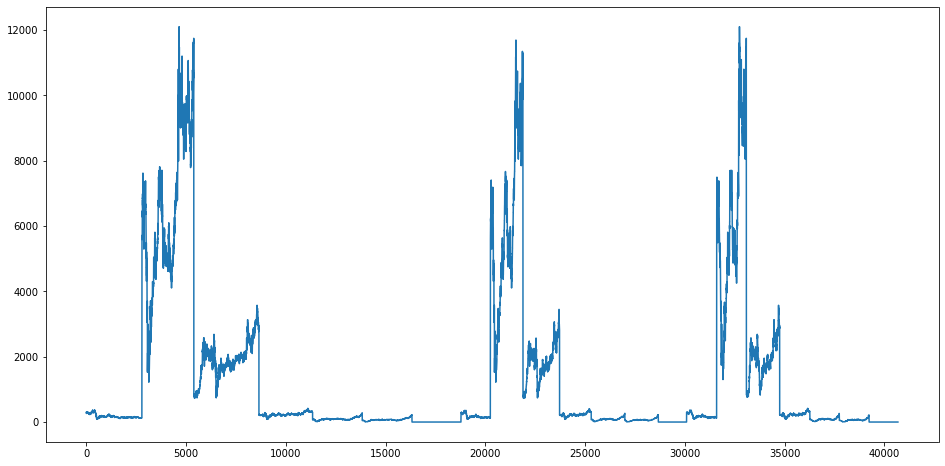

In [304]:
plt.figure(figsize = (16,8))
plt.plot(train_df[1])

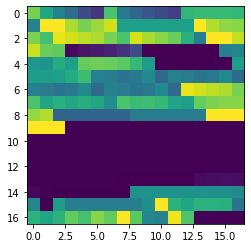

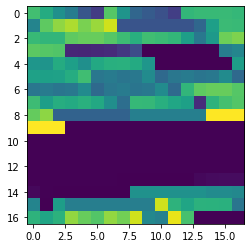

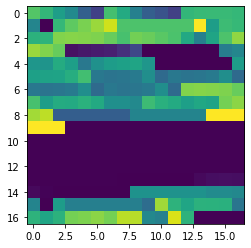

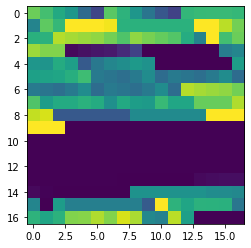

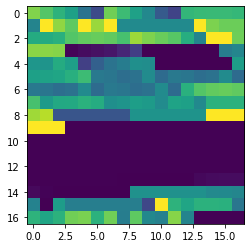

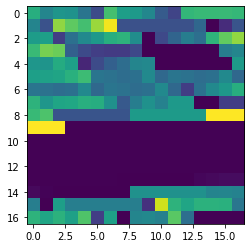

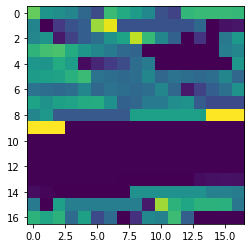

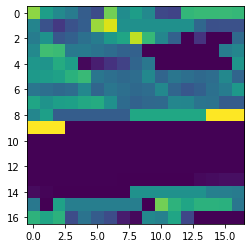

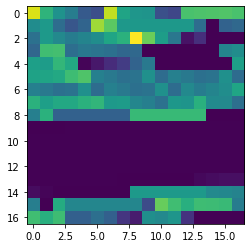

In [307]:
#ПОРИСУЕМ
#train_cnn(train_df, test_df, params)

train_images = train_df.iloc[:, 2:].to_numpy()  # bu satır son sütun hariç her şeyi resimler dataframeine atar.
train_labels = train_df.loc[:, 0]    # bu satır sadece son sütunu alır.
train_prices = train_df.loc[: ,1]

test_images = test_df.iloc[:, 2:].to_numpy()  # bu satır son sütun hariç her şeyi resimler dataframeine atar.
test_labels = test_df.loc[:, 0]   # bu satır sadece son sütunu alır.
test_prices = test_df.loc[:, 1]

test_labels = keras.utils.to_categorical(test_labels, params["num_classes"])
train_labels = keras.utils.to_categorical(train_labels, params["num_classes"])

#create pictures simple reshaping 225 in 15x15+1
train_images = train_images.reshape(train_images.shape[0], params["input_w"], params["input_h"]) 
test_images = test_images.reshape(test_images.shape[0], params["input_w"], params["input_h"])
for i in range(1,10):
    plt.imshow(test_images[i])
    plt.show()